In [7]:
import numpy as np
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt 

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing, Holt
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [9]:
import os
print(os.getcwd())


c:\Users\nithi\AppData\Local\Programs\Microsoft VS Code


In [31]:
df = pd.read_csv(r"C:\Users\nithi\OneDrive\Desktop\Data analyst notes\Projects\time series forecasting\monthly_csv.csv")
df.head()

,Date,Price
0,1950-01,34.73
1,1950-02,34.73
2,1950-03,34.73
3,1950-04,34.73
4,1950-05,34.73


In [13]:
df.shape

(847, 2)

### Let's do some EDA(Exploratory Data Analyis)

In [18]:
print(f"Data range of gold prices available from - {df.loc[:,'Date'][0]} to {df.loc[:,'Date'][len(df)-1]}")

Data range of gold prices available from - 1950-01 to 2020-07


In [19]:
date = pd.date_range(start= '1/1/1950', end= '8/1/2020',freq='M')
date

DatetimeIndex(['1950-01-31', '1950-02-28', '1950-03-31', '1950-04-30',
               '1950-05-31', '1950-06-30', '1950-07-31', '1950-08-31',
               '1950-09-30', '1950-10-31',
               ...
               '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
               '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31',
               '2020-06-30', '2020-07-31'],
              dtype='datetime64[ns]', length=847, freq='ME')

In [25]:
df['month'] = date 
df.drop('Date',axis= 1,inplace = True)
df = df.set_index('month')
df.head()

,Price
month,
1950-01-31,34.73
1950-02-28,34.73
1950-03-31,34.73
1950-04-30,34.73
1950-05-31,34.73


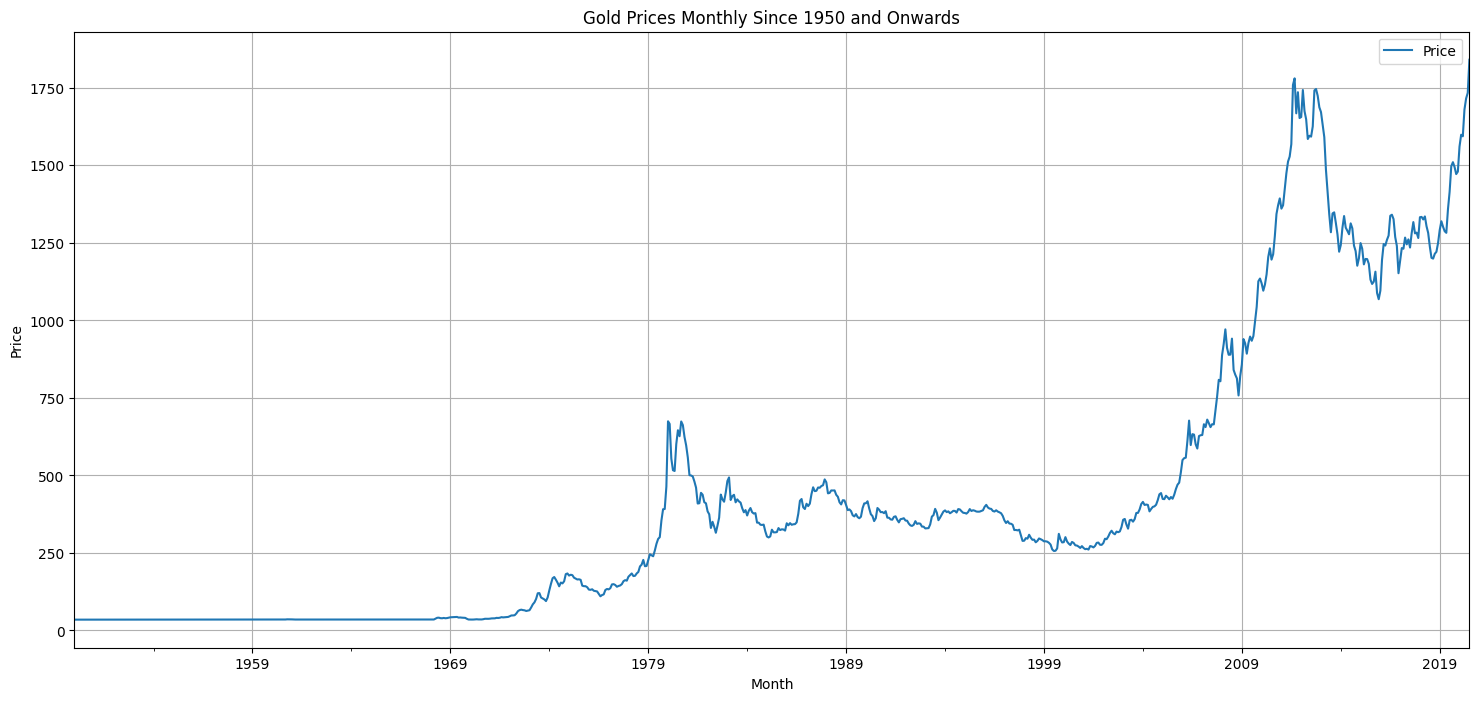

In [28]:
df.plot(figsize=(18,8))
plt.title("Gold Prices Monthly Since 1950 and Onwards")
plt.xlabel('Month')
plt.ylabel('Price')
plt.grid(); 

In [29]:
round(df.describe(),3)

,Price
count,847.000
mean,416.557
std,453.665
min,34.490
25%,35.190
50%,319.622
75%,447.029
max,1840.807


In [37]:
# Convert the 'Date' column to datetime (if it's not already)
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

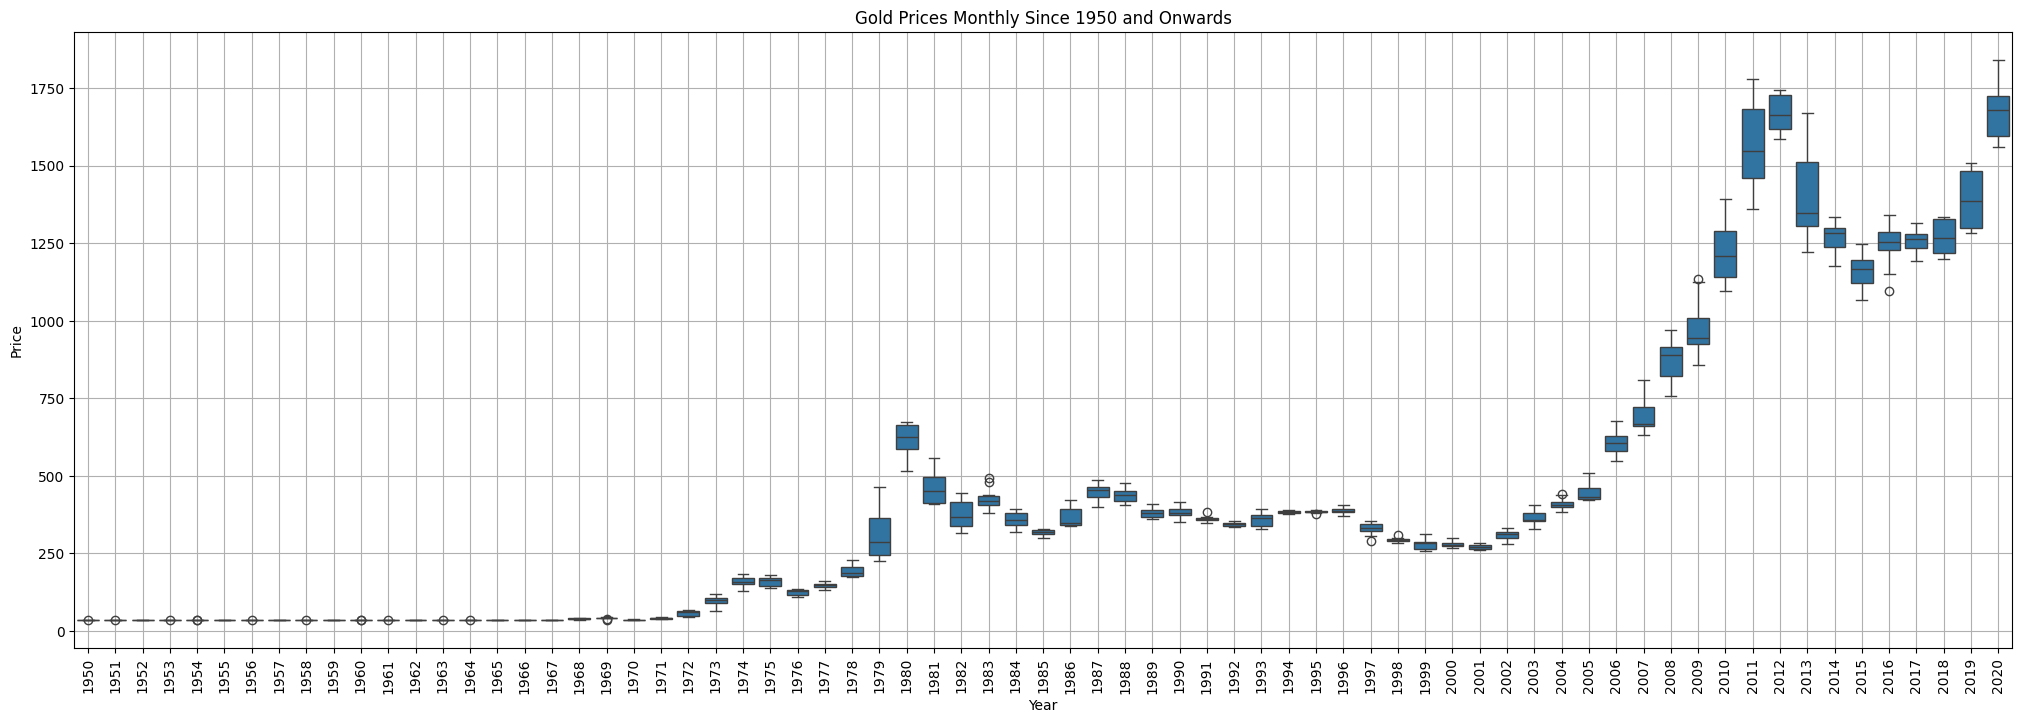

In [50]:
_, ax = plt.subplots(figsize=(25, 8))  # Creates a figure and axes for the plot
sns.boxplot(x=df.index.year, y=df.values[:, 0], ax=ax)  # Creates a boxplot using Seaborn
plt.title("Gold Prices Monthly Since 1950 and Onwards")  # Adds a title to the plot
plt.xlabel('Year')  # Sets the label for the x-axis
plt.ylabel('Price')  # Sets the label for the y-axis
plt.xticks(rotation=90)  # Rotates the x-axis labels by 90 degrees for better visibility
plt.grid(True)  # Enables grid lines on the plot


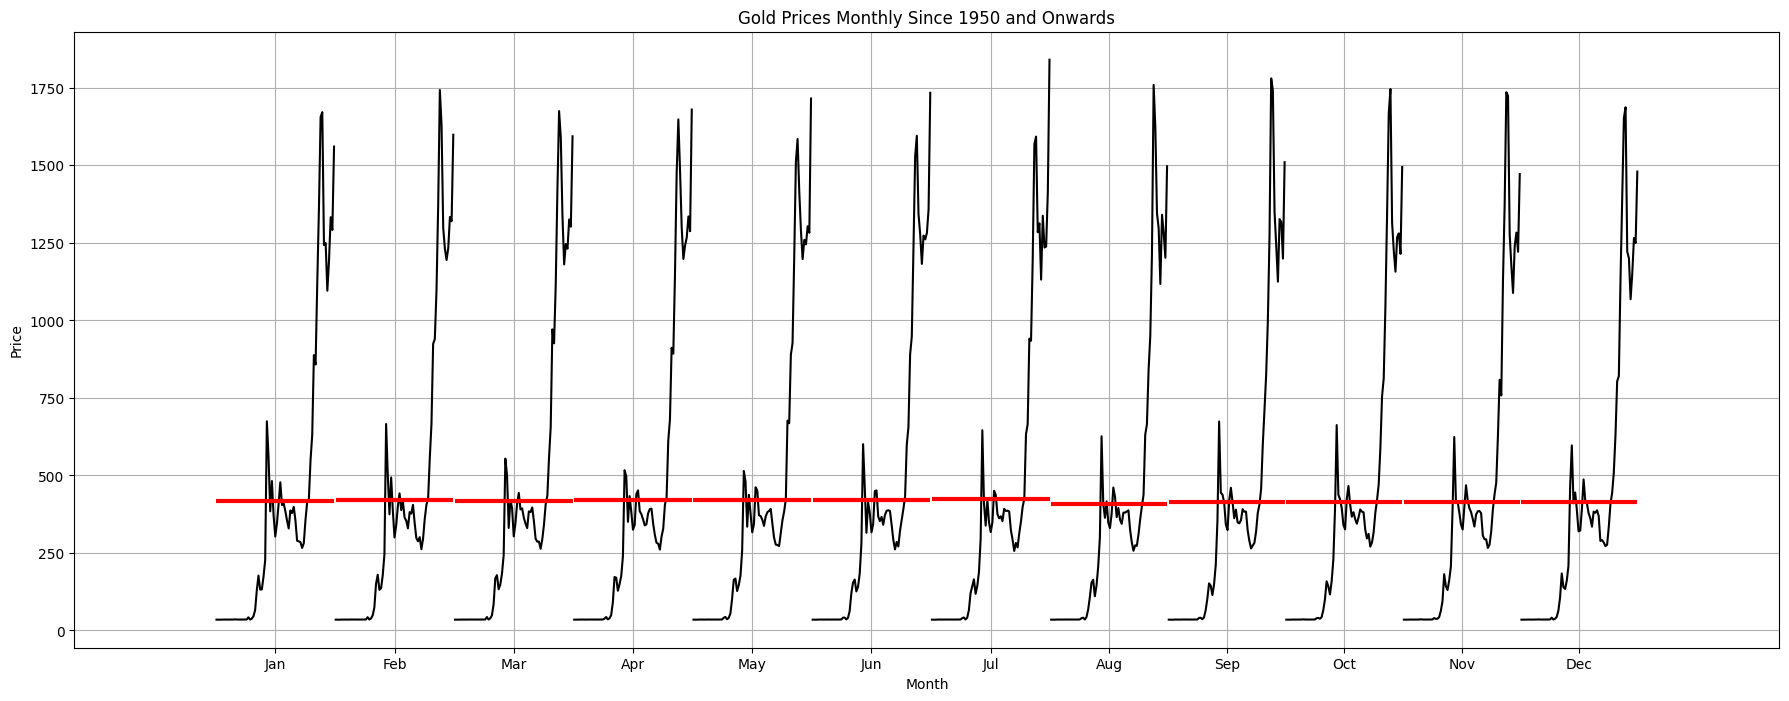

In [53]:
from statsmodels.graphics.tsaplots import month_plot

fig, ax = plt.subplots(figsize=(22, 8))  # Creates a figure and axes for plotting
month_plot(df, ylabel='Gold price', ax=ax)  # Plots the data using the month_plot function
plt.title("Gold Prices Monthly Since 1950 and Onwards")  # Adds a title to the plot
plt.xlabel('Month')
plt.ylabel('Price')
plt.grid()  # Displays the plot


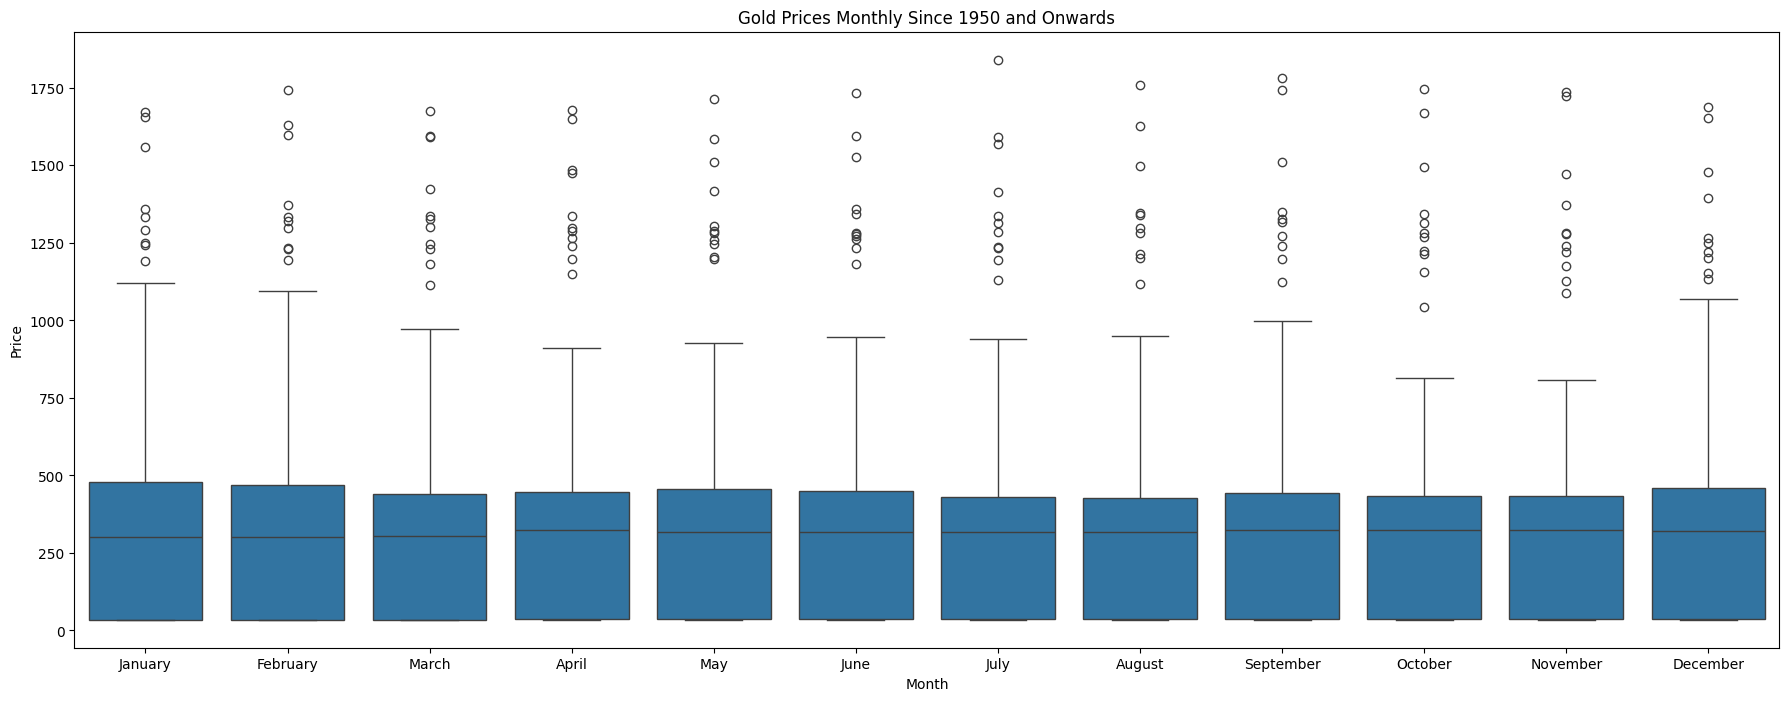

In [54]:
_,ax = plt.subplots(figsize = (22,8))
sns.boxplot(x = df.index.month_name() , y = df.values[:,0], ax=ax)
plt.title("Gold Prices Monthly Since 1950 and Onwards")
plt.xlabel('Month')
plt.ylabel('Price')
plt.show();

#### Average Gold price since 1950 in different frequencies

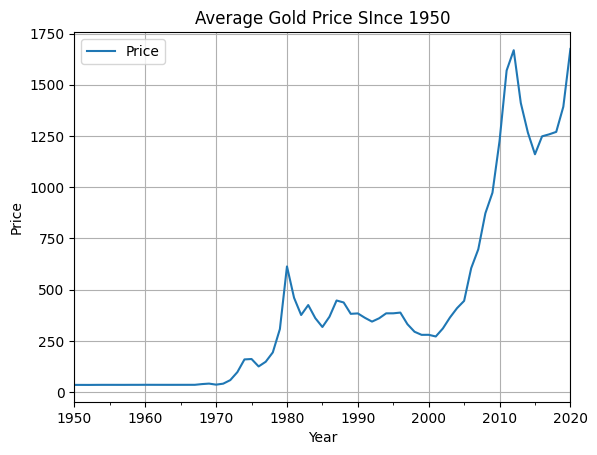

In [ ]:
df_yearly_sum = df.resample('A').mean()
df_yearly_sum.plot()
plt.title("Average Gold Price Yearly Since 1950")
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid()


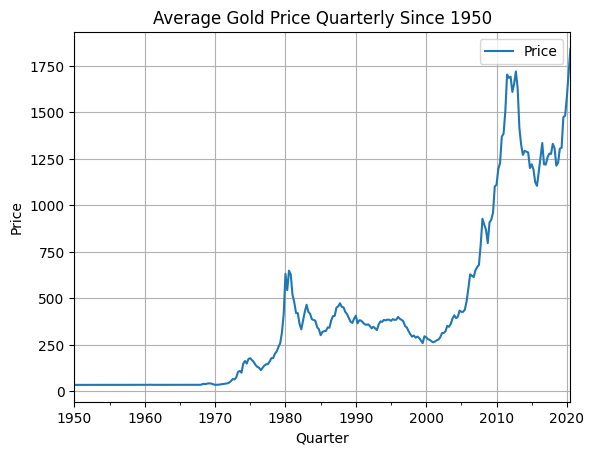

In [64]:
df_quartely_sum = df.resample('Q').mean()  # Resample the data to get quarterly averages
df_quartely_sum.plot()  # Add parentheses to actually plot the data. In () you can do figsize also
plt.title("Average Gold Price Quarterly Since 1950")  # Title for the plot
plt.xlabel('Quarter')  # Label for the x-axis
plt.ylabel('Price')  # Label for the y-axis
plt.grid()  # Display the plot


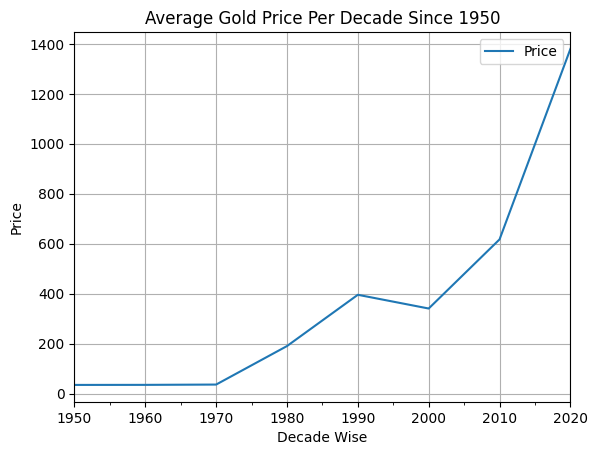

In [69]:
df_deacade_sum = df.resample('10Y').mean()
df_deacade_sum.plot()
plt.title("Average Gold Price Per Decade Since 1950")
plt.xlabel('Decade Wise')
plt.ylabel('Price')
plt.grid()

#### Let's do analysis in co-effiecient of variation

In [77]:
print(df_1.columns)


Index(['Price', 'std'], dtype='object')


In [81]:
# Calculate the mean by year and rename the 'Price' column to 'Mean'
df_1 = df.groupby(df.index.year)['Price'].mean().rename('Mean')

# Calculate the standard deviation by year and rename the 'Price' column to 'std'
df_std = df.groupby(df.index.year)['Price'].std().rename('std')

# Merge the mean and standard deviation DataFrames
df_1 = df_1.to_frame().merge(df_std.to_frame(), left_index=True, right_index=True)

# Calculate the coefficient of variation percentage
df_1['Cov_pct'] = ((df_1['std'] / df_1['Mean']) * 100).round(2)

# Display the first few rows
df_1.head()


,Mean,std,Cov_pct
Date,,,
1950,34.729167,0.002887,0.01
1951,34.717500,0.020057,0.06
1952,34.628333,0.117538,0.34
1953,34.879167,0.056481,0.16
1954,35.020000,0.082792,0.24


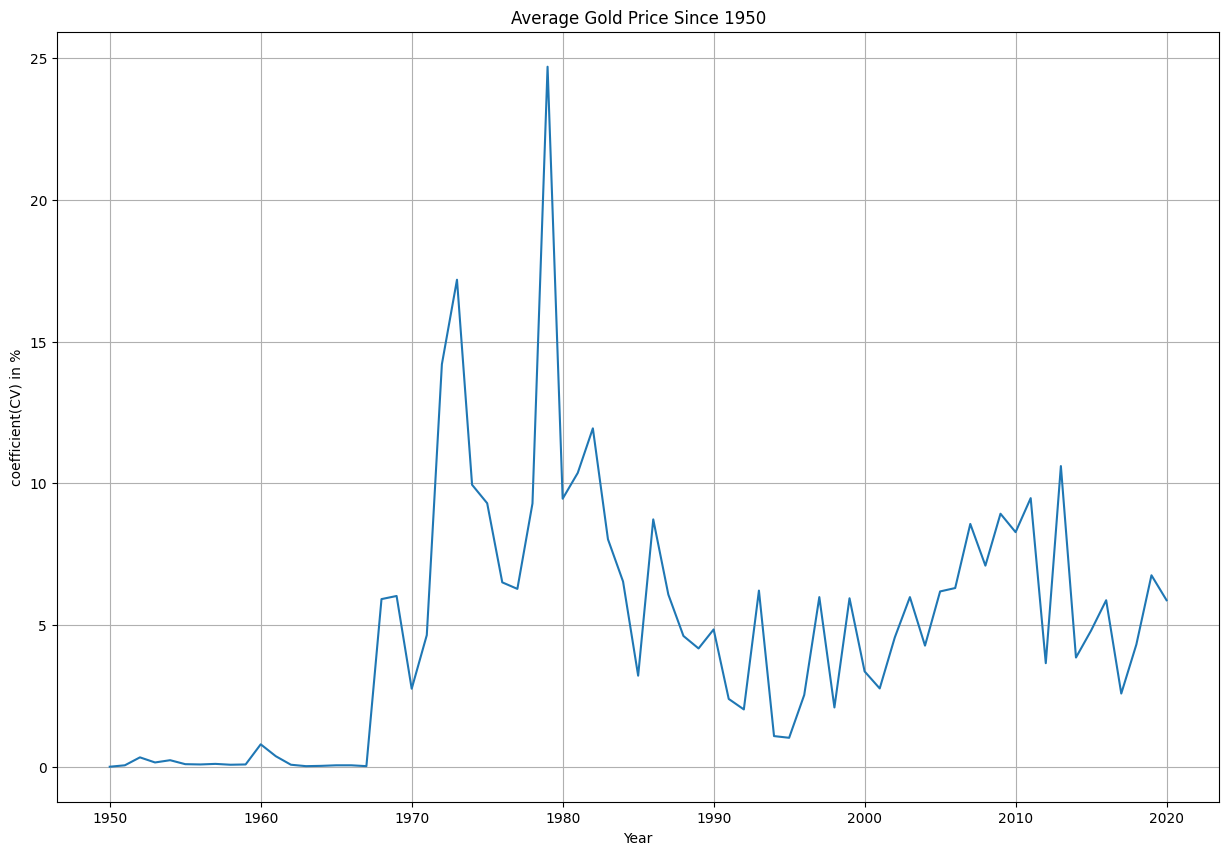

In [84]:
fig, ax= plt.subplots(figsize= (15,10))
df_1['Cov_pct'].plot()
plt.title("Average Gold Price Since 1950")
plt.xlabel('Year')
plt.ylabel('coefficient(CV) in %')
plt.grid()

### Times series forecasting

In [86]:
Train = df[df.index.year <= 2015]
Test = df[df.index.year > 2015]

In [87]:
print(Train.shape)
print(Test.shape)

(792, 1)
(55, 1)


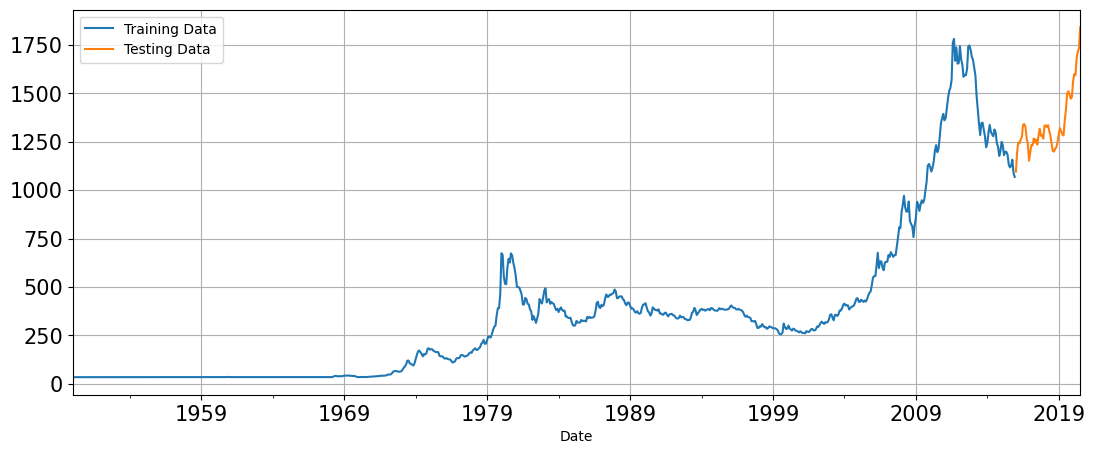

In [89]:
Train["Price"].plot(figsize =(13,5), fontsize = 15)
Test["Price"].plot(figsize= (13,5), fontsize = 15)
plt.grid()
plt.legend(['Training Data', 'Testing Data'])
plt.show()
            

In [90]:
train_time = [i+1 for i in range(len(Train))]
test_time = [i+len(Train)+1 for i in range(len(Test))]
len(train_time),len(test_time)

(792, 55)

In [92]:
LR_train = Train.copy() #LinearRegression
LR_test = Test.copy()


In [93]:
LR_train['time'] = train_time
LR_test['time'] = test_time

In [96]:
lr = LinearRegression()
lr.fit(LR_train[['time']] ,LR_train['Price'].values)

LinearRegression()

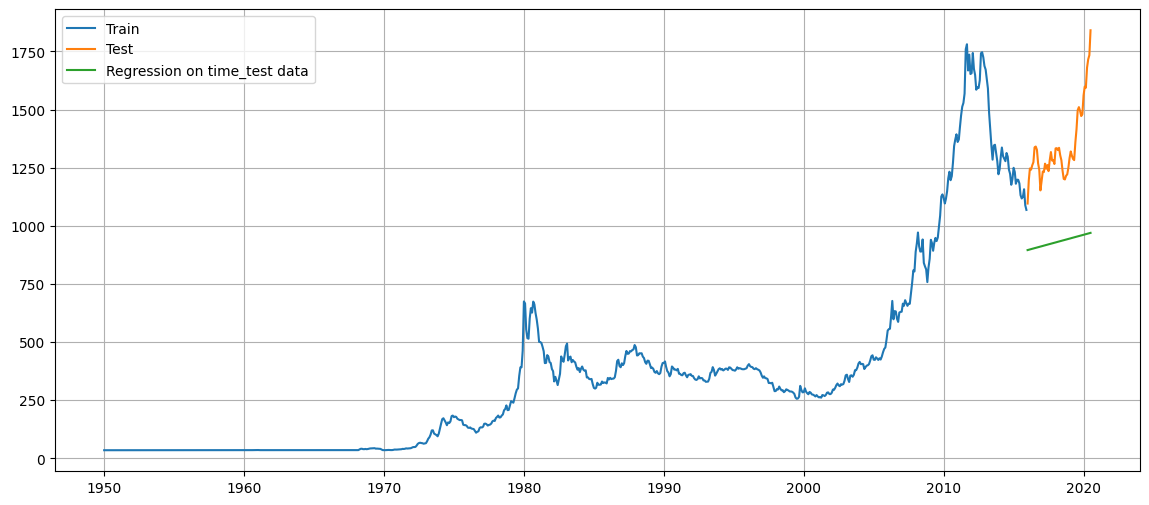

In [141]:
# Predicting values using the linear regression model (lr)
test_prediction_model1 = lr.predict(LR_test[["time"]])

# Adding the predictions as a new column in the LR_test DataFrame
LR_test['forecast'] = test_prediction_model1

plt.figure(figsize= (14,6))
plt.plot(Train['Price'], label = 'Train ')
plt.plot(Test['Price'], label = 'Test')
plt.plot(LR_test['forecast'], label = 'Regression on time_test data')
plt.legend(loc = 'best')
plt.grid()

In [100]:
def mape(actual,pred):
    return round((np.mean(abs(actual - pred)/ actual))*100,2)


In [143]:
# Assuming you have the mape function defined earlier:
mape_model1_test = mape(Test['Price'].values, test_prediction_model1)

# Printing the MAPE with 3 decimal places
print("Mape is %3.3f" % (mape_model1_test), "%")


Mape is 29.760 %


In [144]:
# Assuming you already have the mape_model1_test value from earlier
results = pd.DataFrame({'Test Mape (%)': [mape_model1_test]}, index=["RegressionOnTime"])

# Display the results
print(results)


                  Test Mape (%)
RegressionOnTime          29.76


In [145]:
Naive_train = Train.copy() 
Naive_test = Test.copy()

In [155]:
# Assign the last value of Train['Price'] to every row in Naive_test
Naive_test['naive'] = Train['Price'].iloc[-1]

# Verify 'naive' column exists now
print(Naive_test.head())


               Price     naive
Date                          
2016-01-01  1095.655  1068.317
2016-02-01  1194.893  1068.317
2016-03-01  1246.312  1068.317
2016-04-01  1241.452  1068.317
2016-05-01  1259.755  1068.317


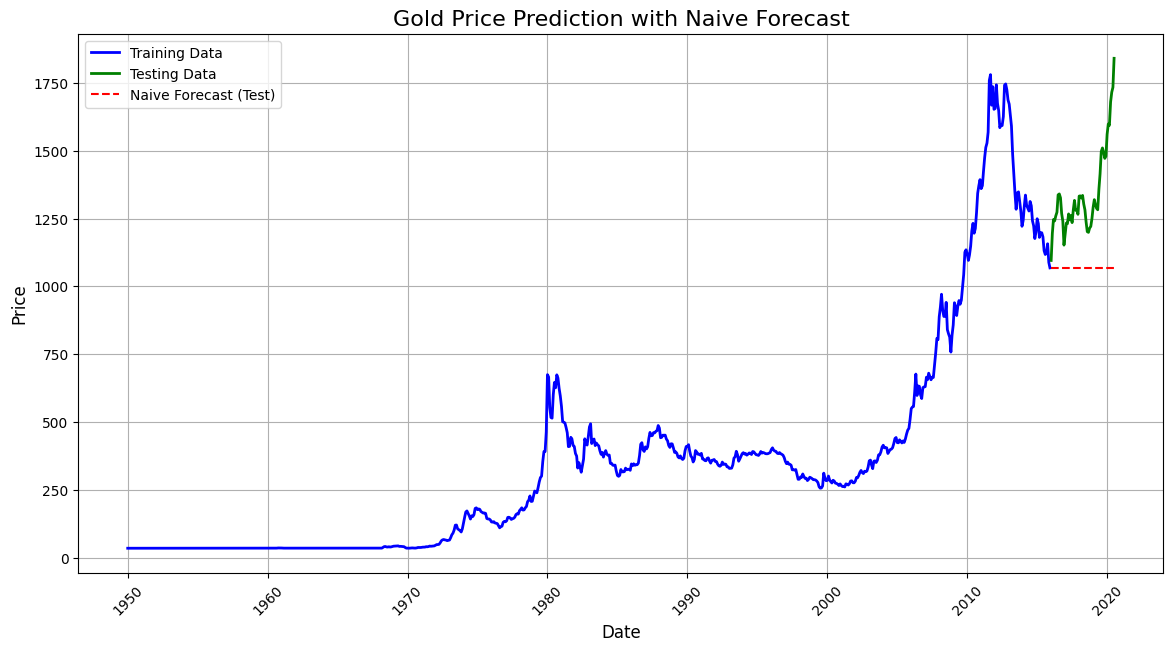

In [121]:
# Now, let's plot the data including the naive forecast
plt.figure(figsize=(14,7))

# Plotting the actual 'Price' values for training and testing data
plt.plot(Train.index, Train['Price'], label='Training Data', color='blue', linewidth=2)
plt.plot(Test.index, Test['Price'], label='Testing Data', color='green', linewidth=2)

# Plotting the naive forecast for testing data
plt.plot(Naive_test.index, Naive_test['naive'], label='Naive Forecast (Test)', linestyle='--', color='red')

# Adding titles and labels
plt.title("Gold Price Prediction with Naive Forecast", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price", fontsize=12)

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45)

# Adding a grid for better visualization
plt.grid(True)

# Adding a legend
plt.legend()

# Display the plot
plt.show()


In [156]:
# Assuming mape function is defined as earlier
mape_model2_test = mape(Test['Price'].values, Naive_test['naive'].values)

print("For Naive forecast on the Test Data, MAPE is %3.3f" %(mape_model2_test), "%")

For Naive forecast on the Test Data, MAPE is 19.380 %


In [152]:
resultsDf_2 = pd.DataFrame({'Test Mape (%)': [mape_model2_test]}, index= ['NaiveModel'])
results = pd.concat([results, resultsDf_2])
results

,Test Mape (%)
RegressionOnTime,29.76
NaiveModel,19.38


In [126]:
final_model = ExponentialSmoothing(df,
                                   trend= 'additive',
                                   seasonal='additive').fit(smoothing_level= 0.4,
                                                            smoothing_trend= 0.3,
                                                            smoothing_seasonal= 0.6)

In [127]:
mape_final_model = mape(df['Price'].values, final_model.fittedvalues)
print("MAPE:",mape_final_model)

MAPE: 17.24


In [130]:
Predictions = final_model.forecast(steps=len(Test))

In [138]:
# Calculate the confidence intervals
pred_df = pd.DataFrame({'lower_CI': Prediction - 1.96 * np.std(final_model.resid, ddof=1),
                        'Prediction': Prediction,  # Fixed here, using Prediction instead of a string
                        'upper_CI': Prediction + 1.96 * np.std(final_model.resid, ddof=1)})

# Display the first few rows of the DataFrame with the confidence intervals
pred_df.head()


,lower_CI,Prediction,upper_CI
2016-01-01,949.674268,1057.825240,1165.976213
2016-02-01,900.764615,1008.915588,1117.066560
2016-03-01,926.376209,1034.527181,1142.678153
2016-04-01,1025.105869,1133.256842,1241.407814
2016-05-01,1076.569461,1184.720434,1292.871406


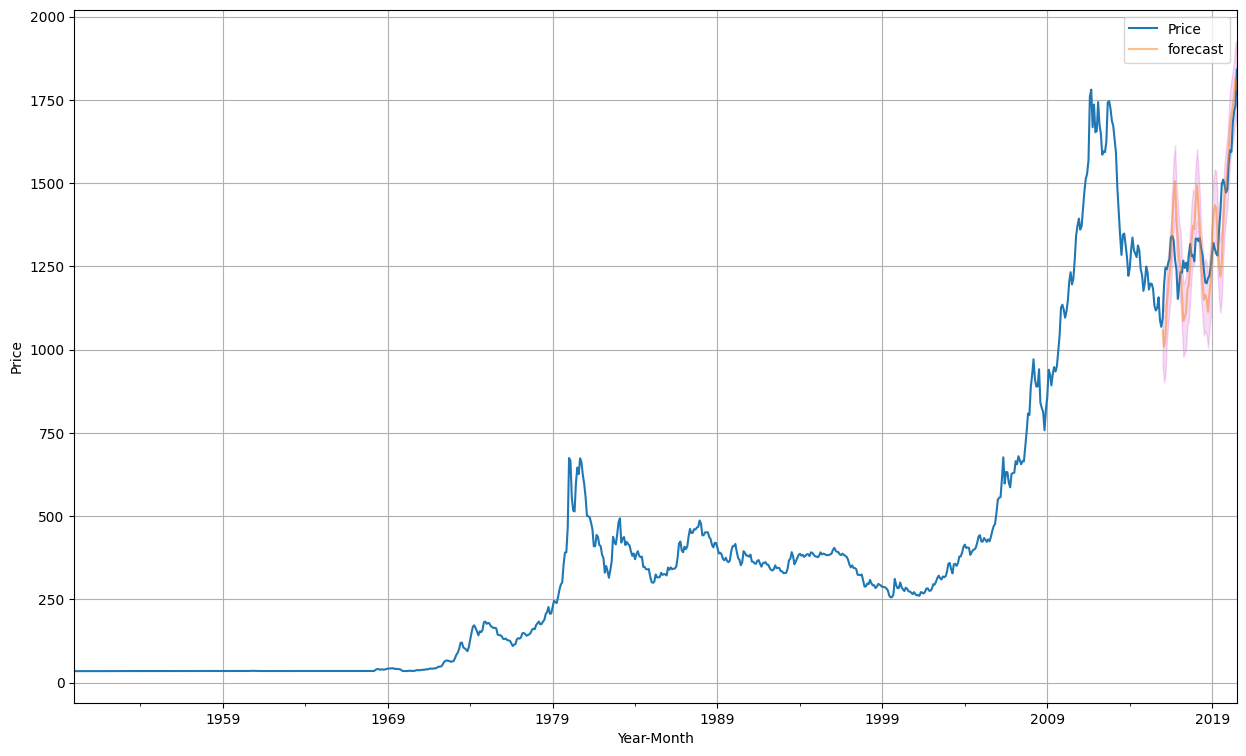

In [140]:
axis = df.plot(label= 'Actual',figsize=(15,9))
pred_df['Prediction'].plot(ax= axis, label = 'forecast', alpha = 0.5)
axis.fill_between(pred_df.index,pred_df['lower_CI'],pred_df['upper_CI'], color= 'm',alpha = .15)
axis.set_xlabel('Year-Month')
axis.set_ylabel('Price')
plt.legend(loc = 'best')
plt.grid()
plt.show()